# Patient Selection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Libraries and Load Data

## 1-1. Import Libraries

In [2]:
!cd /content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
!pip install aequitas
import aequitas as ae

# helper functions
!from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.1/658.1 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/bin/bash: line 1: from: command not found


## 1-2. Load data



In [4]:
import pandas as pd
import time

dataset_path = "/content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main/data/final_project_dataset.csv"
print(dataset_path)

# Read the CSV file and calculate start time
start_time = time.time()
df = pd.read_csv(dataset_path)

# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head(10).to_string(index=False, justify='left'))

# Calculate and print the number of rows and columns
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)

# create a copy dataframe
df_copy = df.copy()



/content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main/data/final_project_dataset.csv
First few rows of the DataFrame:
 encounter_id  patient_nbr race            gender age     weight  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital payer_code medical_specialty        primary_diagnosis_code other_diagnosis_codes  number_outpatient  number_inpatient  number_emergency  num_lab_procedures  number_diagnoses  num_medications  num_procedures ndc_code   max_glu_serum A1Cresult change readmitted
2278392        8222157           Caucasian Female  [0-10) ?      6                  25                        1                    1                 ?          Pediatrics-Endocrinology 250.83                        ?|?            0                  0                 0                 41                  1                  1               0                      NaN NaN           NaN       No      NO       
 149190       55629189        

## 1-3. Level of dataset

We need to confirm the level (line level, encounter level, or patient level) of our EHR datasets.

In [5]:
# number of distinct encounter ids
num_unique_encounters = df['encounter_id'].nunique()
print("Number of unique encounters: {}".format(num_unique_encounters))

# number of rows in the dataset
print("Total number of rows: {}".format(df.shape[0]))

if num_unique_encounters == df.shape[0]:
    print("Data is at the Encounter Level")
else:
    print("Data is at the Line Level")

Number of unique encounters: 101766
Total number of rows: 143424
Data is at the Line Level


In [6]:
# this code snippet searches for the first patient
# who has more than one encounter and prints the data of the first encounters for that patient.
start_time = time.time()
for patient_id in df['patient_nbr'].unique():
    patient_df = df[df['patient_nbr']==patient_id]
    if patient_df['encounter_id'].nunique() > 1:
        break
print("First few rows of encounters for the selected patient:")
print(patient_df.head().to_string(index=False))
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds and minutes
print("Duration in seconds:", duration_seconds)
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


First few rows of encounters for the selected patient:
 encounter_id  patient_nbr      race gender     age weight  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital payer_code      medical_specialty primary_diagnosis_code other_diagnosis_codes  number_outpatient  number_inpatient  number_emergency  num_lab_procedures  number_diagnoses  num_medications  num_procedures  ndc_code max_glu_serum A1Cresult change readmitted
        40926     85504905 Caucasian Female [40-50)      ?                  1                         3                    7                 7          ? Family/GeneralPractice                    428          250.43|250.6                  0                 0                 1                  60                 8               15               0 0378-7185           NaN       NaN     Ch        <30
        40926     85504905 Caucasian Female [40-50)      ?                  1                         3                    7                 7   

The number of the unique encounter_ids is smaller than the total number of rows in the dataset. Therefore, the dataset is at the **line level**.

Besides `encounter_id` and `patient_nbr`, we should also group **all columns except the ndc_code columns** because those values are the same during the same encounter visit.

In [7]:
import pandas as pd
import numpy as np
import time

# Assuming df is defined in your code
enc_cols = ['ndc_code']
enc_grps = [x for x in df.columns if x not in enc_cols]

# Start time calculation
start_time = time.time()

# Group into encounter level
enc_df = df.groupby(enc_grps)[enc_cols].agg(lambda x: list([y for y in x if y is not np.nan])).reset_index()

# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(enc_df.head().to_string(index=False, justify='left'))

# Print the number of rows and columns
num_rows, num_columns = enc_df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)


First few rows of the DataFrame:
 encounter_id  patient_nbr race            gender age     weight  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital payer_code medical_specialty primary_diagnosis_code other_diagnosis_codes  number_outpatient  number_inpatient  number_emergency  num_lab_procedures  number_diagnoses  num_medications  num_procedures max_glu_serum A1Cresult change readmitted ndc_code              
2521974        80499960          Caucasian   Male [80-90) ?      6                  3                         7                     5                ?          ?                    332                     294|425           0                  0                 0                 47                  5                  6               1               >200          Norm      No     <30                            []
2595612        89193870          Caucasian Female [40-50) ?      6                  1                         7                     2      

We can confirm that this is not at the encounter level because the total number of rows is equal to the number of unique encounter_ids.

In [8]:
#These conditions are met if the number of rows in the DataFrame is equal to the number of unique values
# in the column "encounter_id". This implies that each value in the "encounter_id" column is unique,
# representing a distinct encounter.
enc_df.shape[0] == enc_df['encounter_id'].nunique()

True

# 2. Exploratory Data Analysis

## 2-1. Missing Values

To explore the distributions of the features, I created a copy of the dataset and replaced "?" with np.nan

In [9]:
# Start time calculation
start_time = time.time()

# Assuming enc_df is defined in your code
df_eda = enc_df.copy()
df_eda = df_eda.replace(["?", "None"], np.nan)

# Print the first row of the DataFrame
print("First row of the DataFrame:")
print(df_eda.head(10).to_string(index=False, justify='left'))

end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)

First row of the DataFrame:
 encounter_id  patient_nbr race            gender age      weight  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital payer_code medical_specialty primary_diagnosis_code other_diagnosis_codes  number_outpatient  number_inpatient  number_emergency  num_lab_procedures  number_diagnoses  num_medications  num_procedures max_glu_serum A1Cresult change readmitted ndc_code              
 2521974       80499960          Caucasian   Male [80-90) NaN     6                  3                         7                     5                NaN                     NaN     332                     294|425           0                  0                 0                  47                 5                  6               1               >200          Norm      No     <30                            []
 2595612       89193870          Caucasian Female [40-50) NaN     6                  1                         7                     2        

<ipython-input-9-3b06354a2f5d>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eda = df_eda.replace(["?", "None"], np.nan)


From the cell below we see that:

1. `weight` (96.8%), `payer_code` (39.5%), `medical_specialty` (49%), `max_glu_serum` (94.7%), and `A1Cresult` (83.2%) have high amount of missing vallues.

2. `race` (2%) and `primary_diagnosis_code` (0.02%) have less missing values.

In [10]:
na_df = pd.DataFrame(df_eda.isna().sum(), columns=['num_nas'])
na_df['Percentage'] = na_df['num_nas']/df_eda.shape[0]
na_df

,num_nas,Percentage
encounter_id,0,0.000000
patient_nbr,0,0.000000
race,6,0.020134
gender,0,0.000000
age,0,0.000000
weight,298,1.000000
admission_type_id,0,0.000000
discharge_disposition_id,0,0.000000
admission_source_id,0,0.000000
time_in_hospital,0,0.000000


## 2-2. Distribution of Numeric Columns

In [11]:
import seaborn as sns

The distribution of `age` is not Gaussian. The `weight` distribution looks like Gaussian. However, the distribution is truncated below 0.

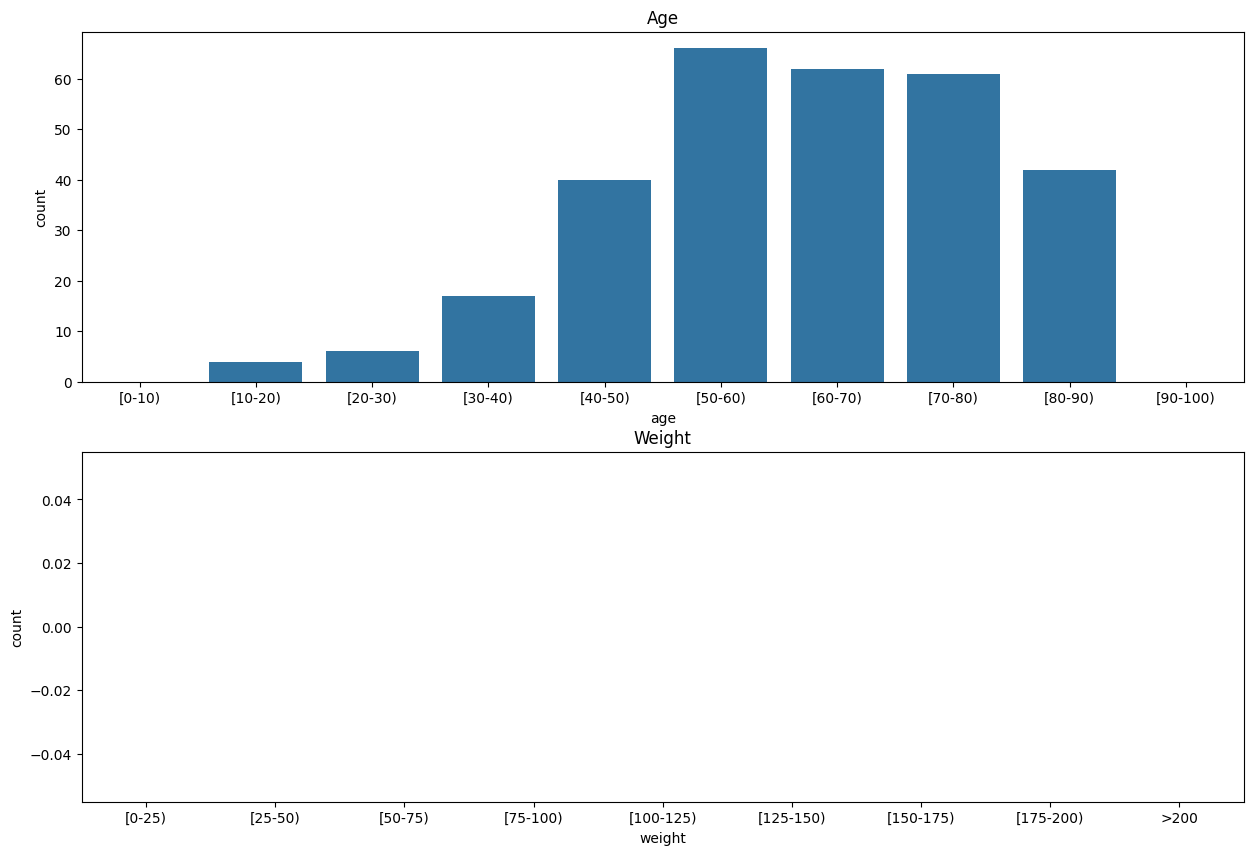

In [12]:
# Distribution of Age
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
ax = sns.countplot(x="age", data=df_eda,
                   order=['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
                          '[60-70)', '[70-80)', '[80-90)', '[90-100)'])
ax.set_title('Age')

# Distribution of Weight
plt.subplot(2, 1, 2)
ax = sns.countplot(x="weight", data=df_eda,
                   order=['[0-25)', '[25-50)', '[50-75)', '[75-100)', '[100-125)', '[125-150)',
                          '[150-175)', '[175-200)', '>200'])
ax.set_title('Weight')
plt.show()


From the histograms below, we see that `num_lab_procedures` looks like Gaussian (however there's a second peak close to 0).

On the other hand, `number_outpatient`, `number_inpatient`, `number_emergency`, `number_diagnoses`, `num_medications`, and `num_procedures` are not Gaussian distrubuted.

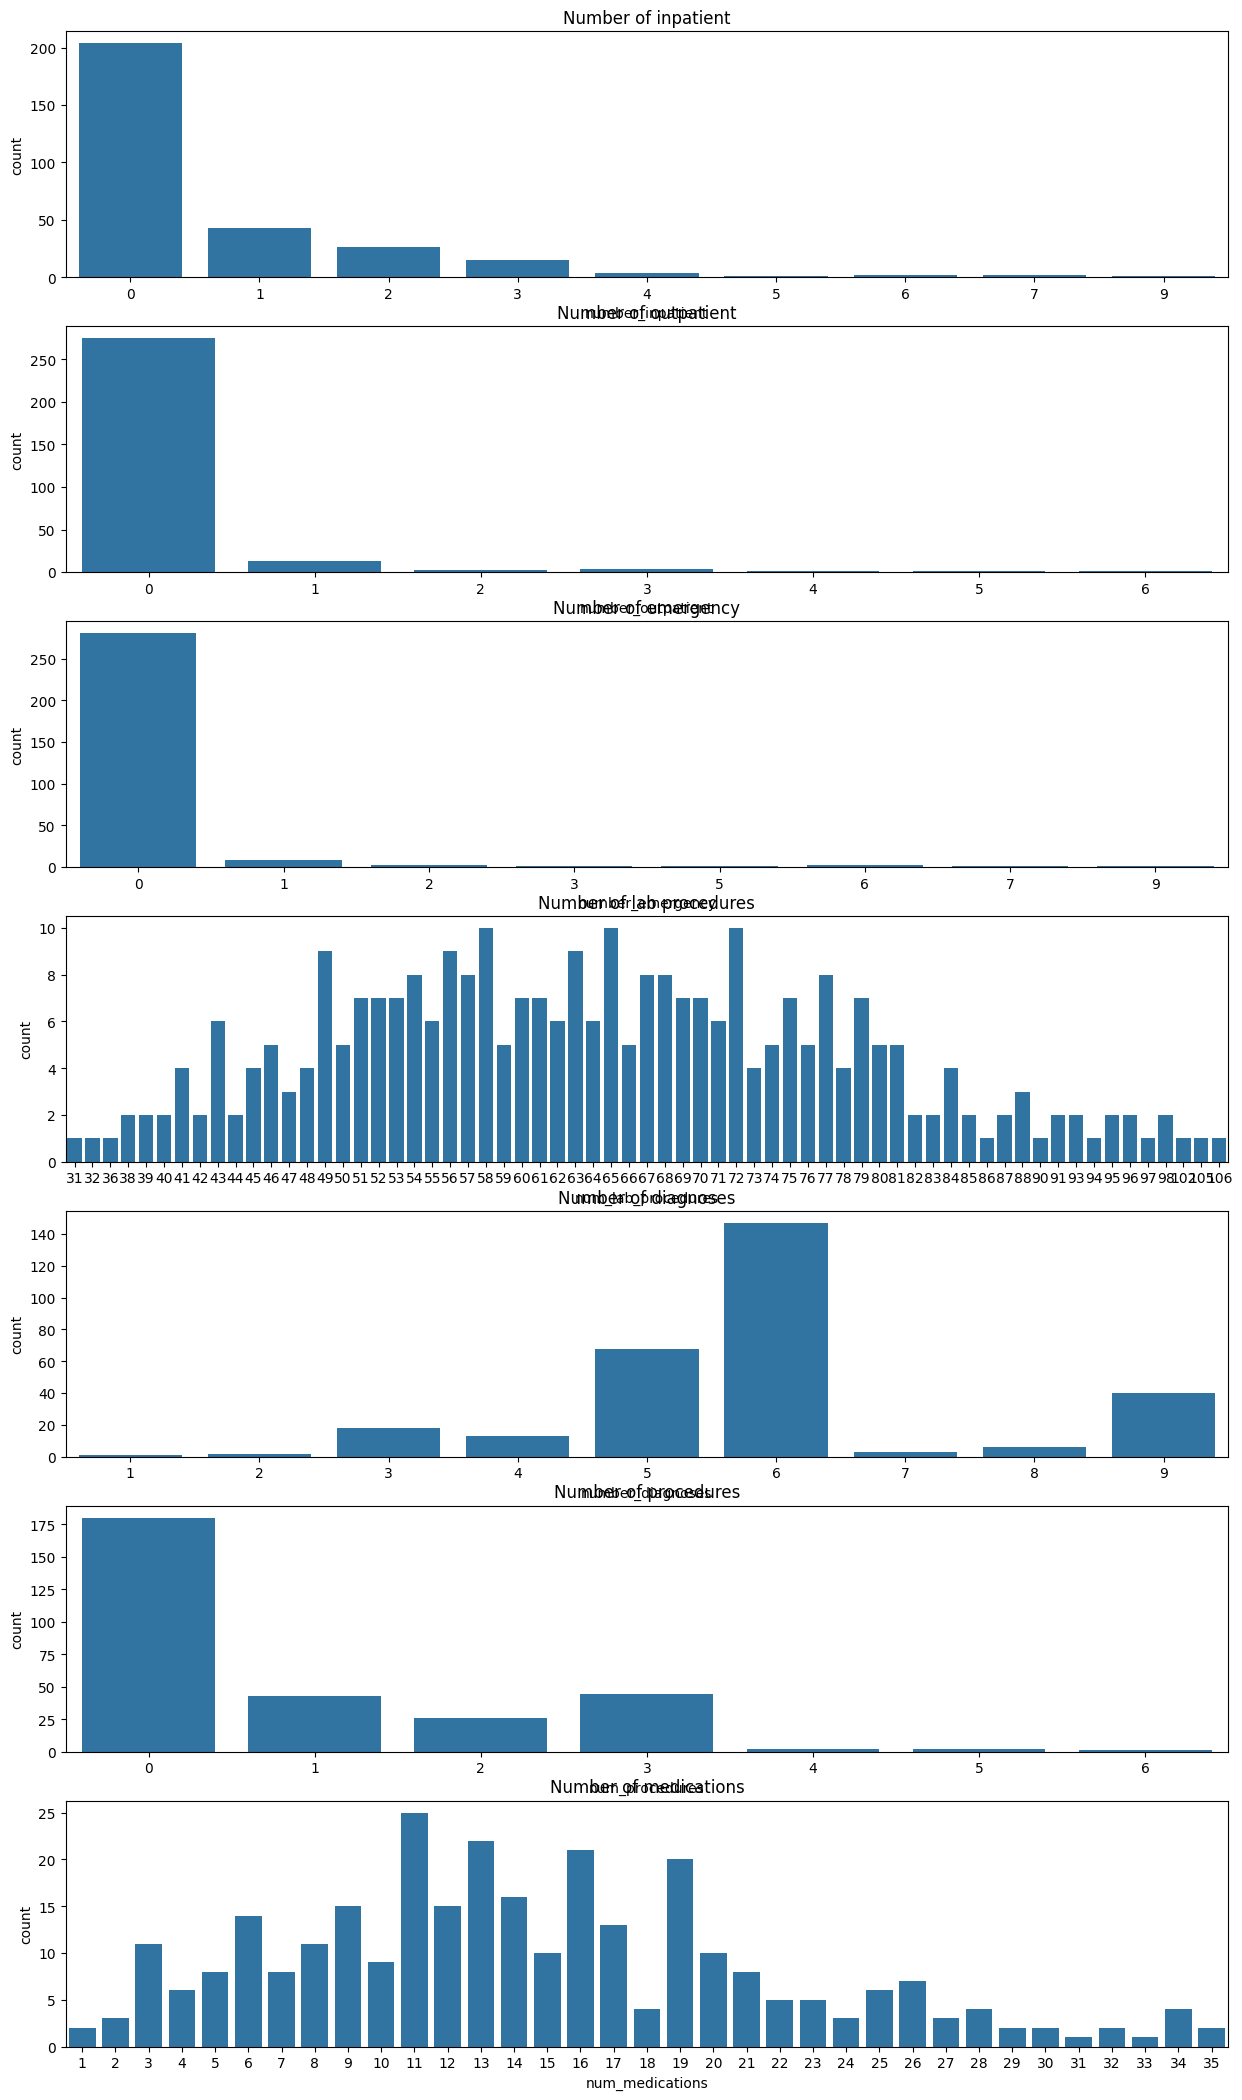

In [13]:
plt.figure(figsize=(15, 30))

# distribution of number_inpatient
plt.subplot(8,1,1)
ax = sns.countplot(x="number_inpatient", data=df_eda)
ax.set_title('Number of inpatient')

# distribution of number_outpatient
plt.subplot(8,1,2)
ax = sns.countplot(x="number_outpatient", data=df_eda)
ax.set_title('Number of outpatient')

# distribution of number_emergency
plt.subplot(8,1,3)
ax = sns.countplot(x="number_emergency", data=df_eda)
ax.set_title('Number of emergency')

# distribution of num_lab_procedures
plt.subplot(8,1,4)
ax = sns.countplot(x="num_lab_procedures", data=df_eda)
ax.set_title('Number of lab procedures')

# distribution of number_diagnoses
plt.subplot(8,1,5)
ax = sns.countplot(x="number_diagnoses", data=df_eda)
ax.set_title('Number of diagnoses')

# distribution of num_procedures
plt.subplot(8,1,6)
ax = sns.countplot(x="num_procedures", data=df_eda)
ax.set_title('Number of procedures')

# distribution of num_medications
plt.subplot(8,1,7)
ax = sns.countplot(x="num_medications", data=df_eda)
ax.set_title('Number of medications')

plt.show()

For `max_glu_serum`, `A1Cresult`, and `readmitted`, there are only 3 distinct categories for each.

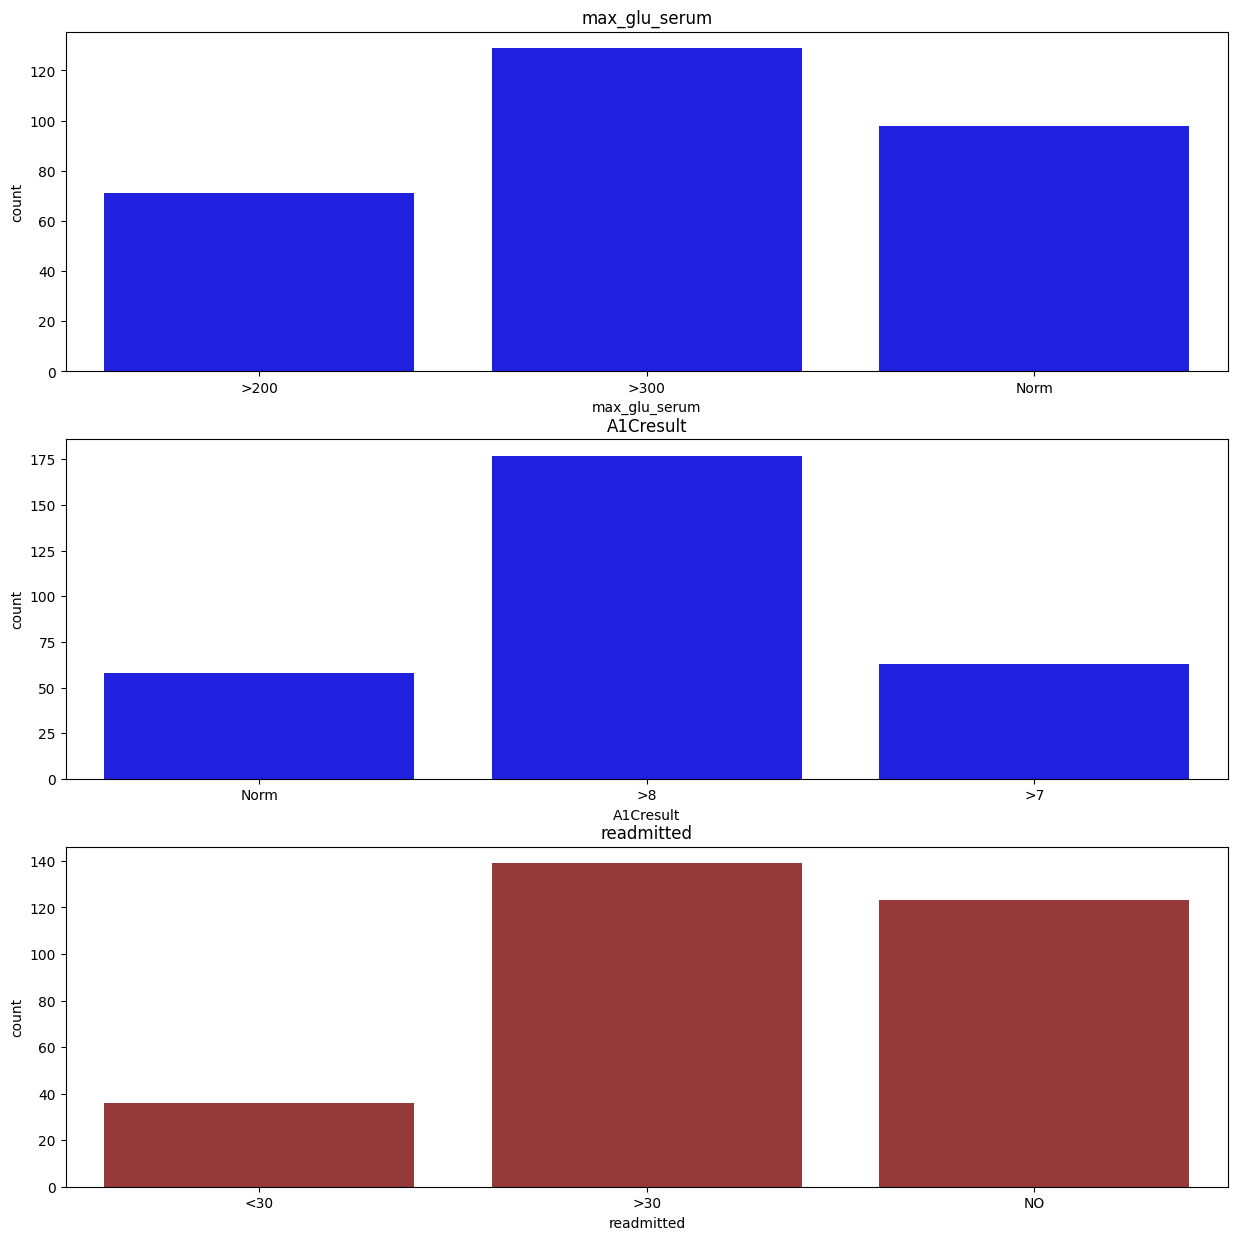

In [14]:
plt.figure(figsize=(15,15))

# distribution of max_glu_serum
plt.subplot(3,1,1)
ax = sns.countplot(x="max_glu_serum", data=df_eda, color="blue" )
ax.set_title('max_glu_serum')

# distribution of A1Cresult
plt.subplot(3,1,2)
ax = sns.countplot(x="A1Cresult", data=df_eda, color="blue")
ax.set_title('A1Cresult')

# distribution of readmitted
plt.subplot(3,1,3)
ax = sns.countplot(x="readmitted", data=df_eda, color="brown")
ax.set_title('readmitted')
plt.show()

Finally, the distribution of `time_in_hospital` (the value we want to predict) is not a Gaussian.

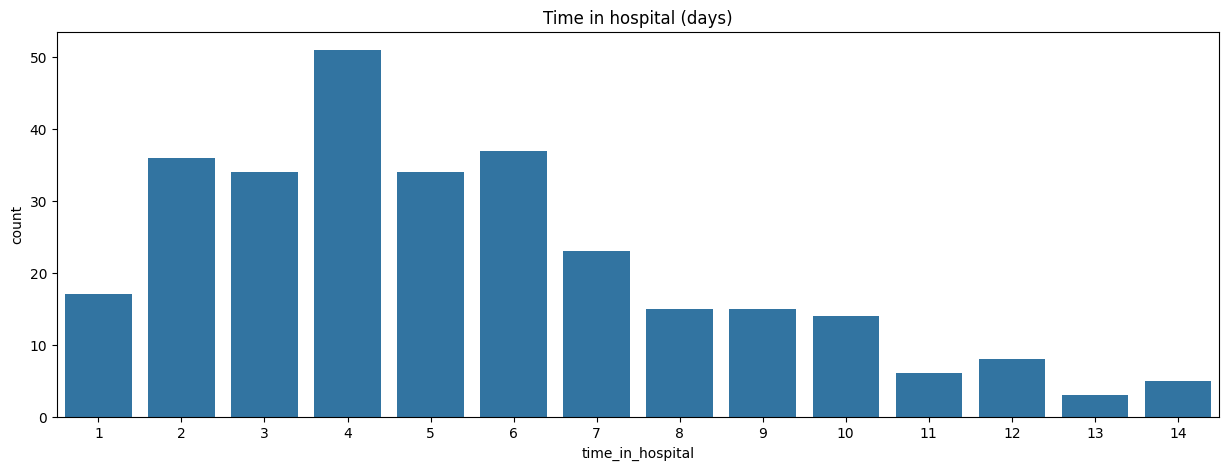

In [15]:
# distribution of time_in_hospital
plt.figure(figsize=(15,5))
ax = sns.countplot(x="time_in_hospital", data=df_eda)
ax.set_title('Time in hospital (days)')
plt.show()

# 3. Data Processing

After understanding the data, we need to perform some processing for the following feature extraction. We will:

1. Reduce the dimensionality of the NDC code (dims=251) to (dims=24)

2. Reduce the number of rows by only selecting the first encounter of each patient

3. Aggregate the dataframe by patient ID


## 3-1. Reduce Dimensionality of the NDC Code

The dimensionality of the NDC codes can be reduced because the same drug can be represented by multiple codes.

In [16]:
# NDC code lookup file
ndc_code_path = "/content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main/medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [17]:
print("Number of unique ndc_code: {}".format(df['ndc_code'].nunique()))
print("Number of unique non-proprietary names: {}".format(ndc_code_df['Non-proprietary Name'].nunique()))

Number of unique ndc_code: 251
Number of unique non-proprietary names: 24


In [18]:
# check if every ndc_code (except np.nan) exists in final_ndc_lookup_table
for x in df['ndc_code'].astype('str').unique():
    if x not in ndc_code_df['NDC_Code'].unique():
        print("{} is not in final_ndc_lookup_table".format(x))

nan is not in final_ndc_lookup_table


In [19]:
%cd /content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main

from student_utils import reduce_dimension_ndc

/content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main


In [20]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [21]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [22]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,NaN,NaN,No,NO,nan
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,NaN,NaN,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,NaN,NaN,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,NaN,NaN,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,NaN,NaN,Ch,NO,Glipizide


In [23]:
reduce_dim_df.shape

(143424, 27)

## 3-2. Select the First Encounter for Each Patient

For this project, we only use the data from the first encounter for each patient.

In [24]:
from student_utils import select_first_encounter

first_encounter_df = select_first_encounter(reduce_dim_df)

In [25]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


In [26]:
print(first_encounter_df.shape)

(101754, 27)


## 3-3. Aggregate Dataframe

In [27]:
# drop ndc_code
first_encounter_df = first_encounter_df.drop('ndc_code', axis=1)

In [28]:
#!pip install utils
#import utils

In [30]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = utils.aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

NameError: name 'utils' is not defined

In [ ]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [ ]:
# show the list of generic drugs
ndc_col_list

In [ ]:
# inpect the data after aggregation
print(agg_drug_df.shape)
agg_drug_df.head()

The dataset is now ready for feature selection.

# 4. Feature Selection and Engineering



In [ ]:
# analysis of the weight data
plt.figure(figsize=(15,5))
weights_data = agg_drug_df['weight'].tolist()
print("ratio of missing values of weights = {}".format(weights_data.count('?')/len(weights_data)))
print("\nDistribution of the availble weight data:")
ax = sns.countplot(x="weight", data=agg_drug_df,
                   order=['[0-25)','[25-50)','[50-75)','[75-100)','[100-125)','[125-150)',
                          '[150-175)', '[175-200)', '>200'])
ax.set_title('Weight')
plt.show()

In [31]:
import utils

In [33]:
# required columns (Udacity)
required_demo_col_list = ['race', 'gender', 'age']

# selected categorical columns (excluding ndc drugs)
# ndc_col_list was not defined. Creating an empty list for now.
# Replace this with the actual list of NDC drug columns
ndc_col_list = []

student_categorical_col_list = ['admission_source_id', 'max_glu_serum', 'A1Cresult'] + required_demo_col_list + ndc_col_list

# selected numerical columns
student_numerical_col_list = ['num_medications', 'num_lab_procedures']

PREDICTOR_FIELD = 'time_in_hospital'

In [34]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):

    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list

    return agg_drug_df[selected_col_list]

In [36]:
# Create a sample agg_drug_df DataFrame (replace this with your actual DataFrame)
agg_drug_df = pd.DataFrame({'patient_nbr': [1, 2, 3],
                            'time_in_hospital': [5, 3, 7],
                            'race': ['Caucasian', 'AfricanAmerican', 'Hispanic'],
                            'gender': ['Female', 'Male', 'Female'],
                            'age': [55, 65, 45],
                            'admission_source_id': [1, 2, 3],
                            'max_glu_serum': ['>200', 'None', 'Norm'],
                            'A1Cresult': ['>8', '>7', 'None'],
                            'num_medications': [10, 5, 8],
                            'num_lab_procedures': [5, 2, 4]})

selected_features_df = select_model_features(agg_drug_df,
                                             student_categorical_col_list,
                                             student_numerical_col_list,
                                             PREDICTOR_FIELD)

In [38]:
# see the dataframe with selected features
print(selected_features_df.shape)
selected_features_df.head()

(3, 10)


,patient_nbr,time_in_hospital,admission_source_id,max_glu_serum,A1Cresult,race,gender,age,num_medications,num_lab_procedures
0,1,5,1,>200,>8,Caucasian,Female,55,10,5
1,2,3,2,None,>7,AfricanAmerican,Male,65,5,2
2,3,7,3,Norm,None,Hispanic,Female,45,8,4


## 4-2. Impute Numerical Features by Zeros

In [39]:
processed_df = utils.preprocess_df(selected_features_df,
                             student_categorical_col_list,
                             student_numerical_col_list,
                             PREDICTOR_FIELD,
                             categorical_impute_value='nan',
                             numerical_impute_value=0)

## 4-3. Split Data

We split the data into 60% training dataset, 20% validation dataset, and 20% test dataset. After split, we confirm that there's not data leakage between the partitions.

In [40]:
from student_utils import patient_dataset_splitter

d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [41]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [42]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## 4-4. Demographic Representation Analysis of Split

time_in_hospital
3.0    1
5.0    1
7.0    1
dtype: int64
Axes(0.125,0.11;0.775x0.77)


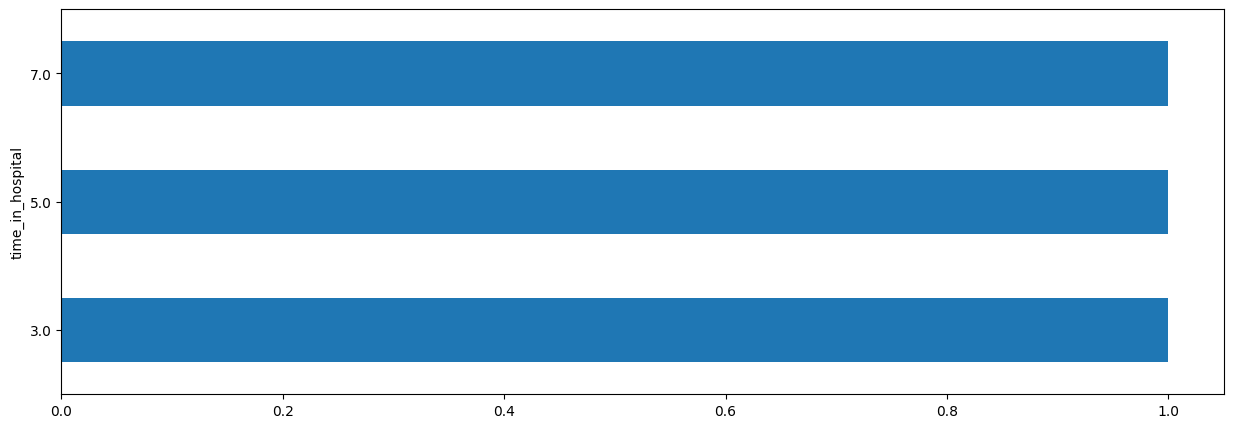

In [43]:
plt.figure(figsize=(15,5))
utils.show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
5.0    1
dtype: int64
Axes(0.125,0.11;0.775x0.77)


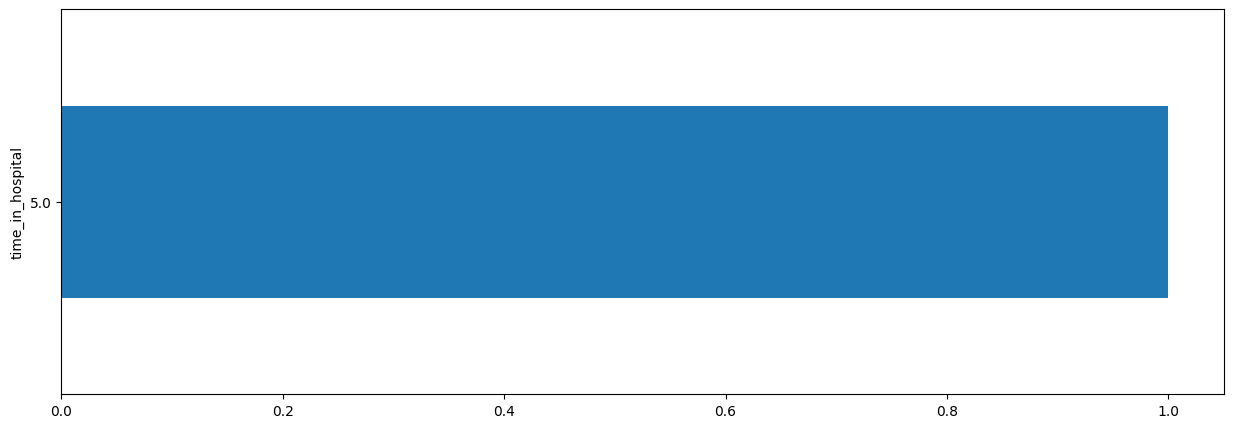

In [44]:
plt.figure(figsize=(15,5))
utils.show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
7.0    1
dtype: int64
Axes(0.125,0.11;0.775x0.77)


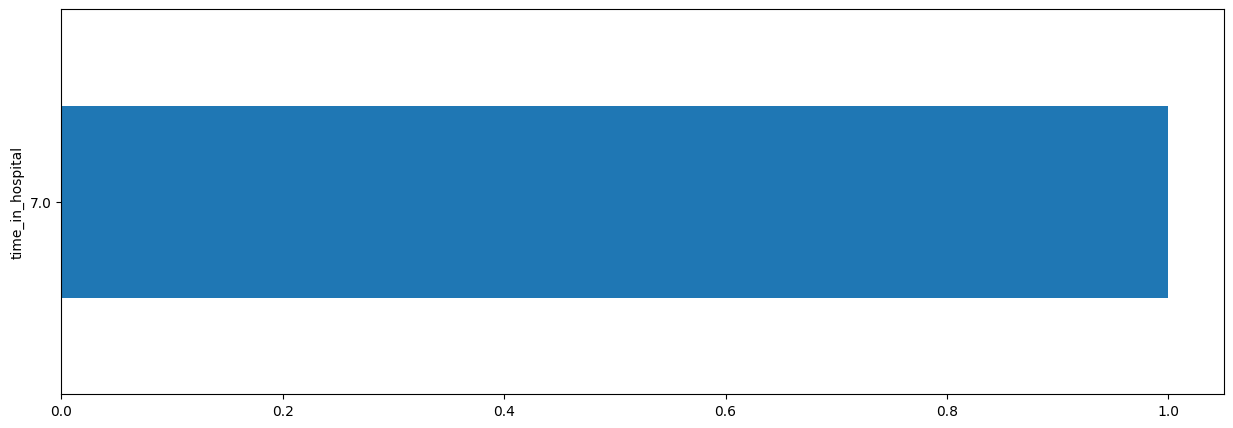

In [45]:
plt.figure(figsize=(15,5))
utils.show_group_stats_viz(d_test, PREDICTOR_FIELD)

gender
Female    2
Male      1
dtype: int64
Axes(0.125,0.11;0.775x0.77)


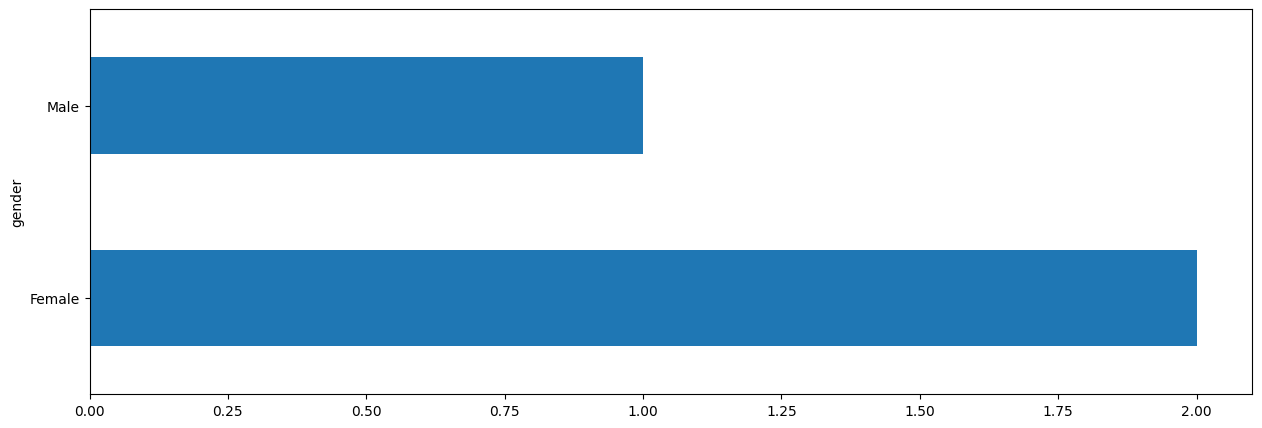

In [46]:
# Full dataset before splitting
plt.figure(figsize=(15,5))
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
utils.show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    1
dtype: int64
Axes(0.125,0.11;0.775x0.77)


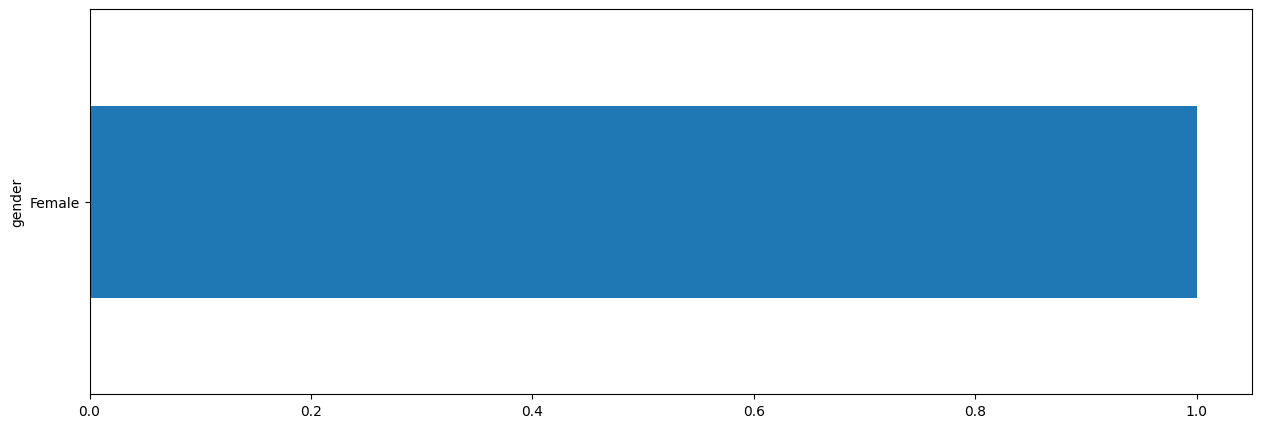

In [47]:
# Training partition
plt.figure(figsize=(15,5))
utils.show_group_stats_viz(d_train, 'gender')

gender
Female    1
dtype: int64
Axes(0.125,0.11;0.775x0.77)


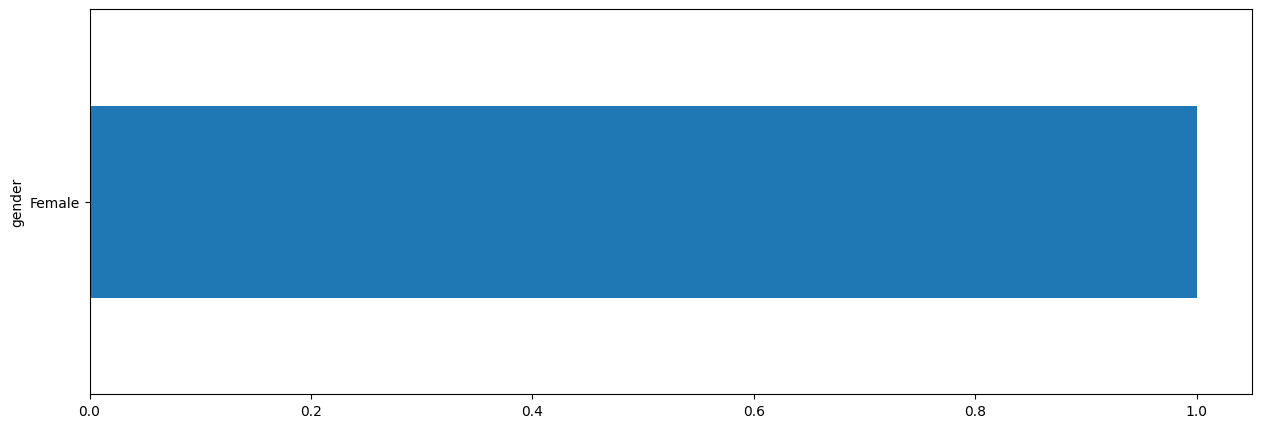

In [48]:
# Test partition
plt.figure(figsize=(15,5))
utils.show_group_stats_viz(d_test, 'gender')

## 4-5. Convert Dataset to TF Dataset

In [49]:
# convert dataset from Pandas dataframes to TF dataset
batch_size = 128
diabetes_train_ds = utils.df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = utils.df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = utils.df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

These messages are notifications indicating that the vocabulary size for some features has been inferred based on the number of elements in the corresponding vocabulary file.

In [50]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

## 4-6. Create Categorical Features with TF Feature Columns

In [51]:
# we adding the directory
!mkdir diabetes_vocab
vocab_file_list = utils.build_vocab_files(d_train, student_categorical_col_list)

mkdir: cannot create directory ‘diabetes_vocab’: File exists


In [52]:
# view the list of vocab files
vocab_file_list

['./diabetes_vocab/admission_source_id_vocab.txt',
 './diabetes_vocab/max_glu_serum_vocab.txt',
 './diabetes_vocab/A1Cresult_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt']

In [53]:
from student_utils import create_tf_categorical_feature_cols

tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [69]:
import tensorflow as tf

# Assuming diabetes_train_ds is already defined and loaded
diabetes_batch = next(iter(diabetes_train_ds))[0]

def demo(feature_column, example_batch):
    # Check the type of feature column and handle accordingly
    if isinstance(feature_column, tf.feature_column.IndicatorColumn):
        # For IndicatorColumns, you don't need CategoryEncoding
        feature_layer = example_batch
    else:
        # For other categorical columns, use CategoryEncoding
        feature_layer = tf.keras.layers.CategoryEncoding(num_tokens=feature_column.num_buckets, output_mode="binary")(example_batch)

    # Print the results
    print(feature_layer.numpy())

# Example categorical feature column
test_cat_var1 = tf_cat_col_list[0]  # Assume this list is correctly defined

# Print the categorical column being tested
print("Example categorical field:\n{}".format(test_cat_var1))

# Check available keys in diabetes_batch
print(f"Available keys in diabetes_batch: {diabetes_batch.keys()}")

# Assuming 'admission_source_id' is the correct key from the diabetes_batch
# Prepare the input dictionary for the feature
input_dict = {test_cat_var1.name: diabetes_batch['admission_source_id']}

# Pass the categorical column and the corresponding batch data to the demo function
demo(test_cat_var1, input_dict)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_source_id', vocabulary_file='./diabetes_vocab/admission_source_id_vocab.txt', vocabulary_size=2, num_oov_buckets=1, dtype=tf.string, default_value=-1, file_format=None))
Available keys in diabetes_batch: dict_keys(['patient_nbr', 'admission_source_id', 'max_glu_serum', 'A1Cresult', 'race', 'gender', 'age', 'num_medications', 'num_lab_procedures'])


AttributeError: module 'tensorflow.feature_column' has no attribute 'IndicatorColumn'

## 4-7. Create Numerical Features

In [ ]:
for col in student_numerical_col_list:
    d_train[col] = d_train[col].astype('float32')
    d_val[col] = d_val[col].astype('float32')
    d_test[col] = d_test[col].astype('float32')

In [ ]:
#Replace the previous code to avoid the warning
for col in student_numerical_col_list:
    d_train.loc[:, col] = d_train[col].astype('float32')
    d_val.loc[:, col] = d_val[col].astype('float32')
    d_test.loc[:, col] = d_test[col].astype('float32')


In [ ]:
import student_utils
import functools
from student_utils import normalize_numeric_with_zscore, create_tf_numeric_feature

In [ ]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [ ]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [ ]:
#test_cont_var1 = tf_cont_col_list[0]
#print("Example continuous field:\n{}\n".format(test_cont_var1))
#demo(test_cont_var1, diabetes_batch)

## 4-8. Combine Features with DenseFeatures

In [ ]:
# concatenate categorical and numeric feature columns
claim_feature_columns = tf_cat_col_list + tf_cont_col_list

# combine with TF DenseFeatures
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

# 5. Build and Train the Model

The model is built with DenseFeatures and TF Probability Layers. The optimizer used is rmsprop. We train the model for 10 epochs.

In [ ]:
!cd /content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main

In [ ]:
import utils
def build_sequential_model(feature_layer):
    """
    Build model
    Args:
        feature_layer - feature layers created by TF DenseFeatures
    Output:
        model - the TF model
    """
    """model = tf.keras.Sequential([feature_layer,
                                 tf.keras.layers.Dense(256, activation='relu'),
                                 tf.keras.layers.Dense(128, activation='relu'),
                                 tfp.layers.DenseVariational(1+1),
                                 tfp.layers.DistributionLambda(
                                     lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                                                       scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))])
    """
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tfp.layers.DenseVariational(1, utils.posterior_mean_field, utils.prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])))
        ])

    return model




def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    """
    Train the model
    Args:
        train_ds - the training dataset
        val_ds - the validation dataset
        feature_layer - feature layers created by TF DenseFeatures
        epochs - number of epochs (default=5)
        loss_metric - the loss function (default=MSE)
    Outputs:
        model - the trained model
        history - history of the metrics
    """
    # build the model
    model = build_sequential_model(feature_layer)

    # compile the model
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])

    # early stop callback
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)

    # train the model
    history = model.fit(train_ds, validation_data=val_ds, callbacks=[early_stop], epochs=epochs)

    return model, history

In [ ]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

In [ ]:
tfp.layers.DenseVariational(1, utils.posterior_mean_field, utils.prior_trainable)

Train for 336 steps": Means that the model is being trained using 336 training steps, where the model's weights are updated after each step.

"Validate for 112 steps": Means that the model's performance is being assessed using a validation set that the model has not been trained on. The performance is measured after every 112 steps.

"epochs=10" means that the model will be trained on the dataset for 10 complete passes.

In [ ]:
# build and train the model
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

# 6. Results

## 6-1. Uncertainty of Model Prediction

We use TF Probability Layer to build the model. As a result, we can extract the mean and standard deviation for each prediction the model made.

In [ ]:
# list of columns used as features
feature_list = student_categorical_col_list + student_numerical_col_list
#
diabetes_x_tst = dict(d_test[feature_list])
#
diabetes_yhat = diabetes_model(diabetes_x_tst)

# predict on the test dataset
preds = diabetes_model.predict(diabetes_test_ds)

In [ ]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

In [ ]:
# create a dict for building the dataframe
prob_outputs = {"pred": preds.flatten(),
                "actual_value": d_test['time_in_hospital'].values,
                "pred_mean": m.numpy().flatten(),
                "pred_std": s.numpy().flatten()}

# convert prob_outputs into a dataframe
prob_output_df = pd.DataFrame(prob_outputs)

In [ ]:
# check the results
prob_output_df.head()

## 6-2. Patient Selection

We use the mean of the prediction to perform binary classification on each patients.

In [ ]:
from student_utils import get_student_binary_prediction

student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

In [ ]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    """
    Create a dataframe for the test dataset with 'score' and 'label_value'.
    'score' is the binary prediction that a patient would spend >= 5 days in the hospital
    'label_value' is the ground truth that a patient spent >= 5 days in the hospital
    Args:
        test_df - the test dataset
        pred_np - the binary prediction of the test dataset by the model
        demo_col_list: the categorical feature names
    Output:
        test_df - dataframe of the test dataset (with score and label_value)
    """

    # convert all values of the categorical columns into strings
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)

    # model binary prediction
    test_df['score'] = pred_np

    # acutal labels
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)

    return test_df


pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [ ]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

# 7. Model Evaluation

## 7-1. Precision and Recall

Precision is the ratio of the number of true positives to the sum of the true positives and false positives. Recall is the ratio of the number of true positives to the sum of the true positives and false negatives. There's a tradeoff between them. If we increase the precision (we say no to the data that we're less confident in classifying as positive), we will classfy more true positives as negative and as a result decreasing the recall. On the other hand, if we increase the recall (by saying yes to the data that we're less confident in classifying it as as negative), we will calssify more true negative data as positive and as a result decreasing the precision.



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

y_true = pred_test_df['label_value']
y_pred = pred_test_df['score']

# AUC, F1, precision and recall
# Summary

auc = roc_auc_score(y_true, y_pred)
print("AUC = {:.4f}\n".format(auc))

f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 score = {:.4f}\n".format(f1))

precision = precision_score(y_true, y_pred)
print("Precision = {:.4f}\n".format(precision))

recall = recall_score(y_true, y_pred)
print("Recall = {:.4f}\n".format(recall))

My model has a **good** recall, but it has not[link text](https://) high precision.

Based on the given results:

    AUC = 0.7070 indicates moderate ability to discriminate between classes.
    F1 score = 0.7306 indicates overall good performance.
    Precision = 0.6347 indicates moderate precision.
    Recall = 0.6174 indicates moderate ability to capture positive cases.

Overall, the results show an acceptable performance of the model. However, there may be some opportunities to improve performance, especially in increasing recall and improving precision.


## 7-2. Biases

We use [Aequitas](https://github.com/dssg/aequitas) to analyze the biases of the model.

Aequitas analysis is used to assess biases in model predictions based on demographic factors. It involves detecting biases in the False Positive Rate (FPR) and False Negative Rate (FNR) across different demographic groups. Fairness is evaluated by analyzing and comparing these metrics between groups. Disparity visualization illustrates differences in FPR across demographic groups, aiding in identifying any biases or gaps in the model.

Overall, these analyses and visualizations provide insight into the fairness of the model's predictions across different demographic groups, aiding in identifying and addressing any biases or gaps present in the model.

In [ ]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness


ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)

g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)

aqp = Plot()
b = Bias()

In [ ]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab,
                                        original_df=ae_df,
                                        ref_groups_dict={'race':'Caucasian', 'gender':'Male'},
                                        alpha=0.05,
                                        check_significance=False)

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [ ]:
# fairness: false positive rate
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

In [ ]:
import matplotlib.pyplot as plt

fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

# دوران المحور 90 درجة
plt.xticks(rotation=90)

plt.show()





In [ ]:
# fairness: false negative rate
fnr_fairness = aqp.plot_fairness_group(fdf, group_metric='fnr', title=True)

## 7-3. Disparity

From the figures below we see that compared to Caucasian (the reference group), all other races have a higher false positive rate.

On the other hand, we don't see this in gender. Gender doesn't not have much influence on the false positive rate.

In [ ]:
# FPR disparity of race
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')

If the false positive rate (FPR) is lower, it means the model is better at classifying negative samples correctly as negatives, indicating better performance in predicting negative outcomes. Therefore, if the value is lower (such as 0.87), it signifies better performance compared to a higher value (like 1.96), hence the value 0.87 is better.

In [ ]:
# FPR disparity of gender
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='gender')